# 01_03_check_fits_quality

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, astropy, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

In [4]:
#import sys
#!pip install astropy==5.2 photutils==1.6 #astroscrappy==1.1.1
#%pip install astroscrappy==1.1.1

In [5]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, photutils, ccdproc, astroscrappy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        #print(f"**** module {pkg} is not installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module photutils is installed
**** module ccdproc is installed
**** module astroscrappy is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2024-12-29 21:56:02 (KST = GMT+0900) 
0 Python     3.12.7 64bit [GCC 11.2.0]
1 IPython    8.27.0
2 OS         Linux 6.8.0 51 generic x86_64 with glibc2.39
3 numpy      1.26.4
4 pandas     2.2.3
5 matplotlib 3.8.4
6 scipy      1.14.1
7 astropy    7.0.0
8 photutils  1.12.0
9 ccdproc    2.4.2
10 astroscrappy 1.2.0
11 version_information 1.0.4


### import modules

In [6]:
#%%
from pathlib import Path
from astropy.io import fits
import subprocess
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ccdproc import combine

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils import DAOStarFinder, detect_threshold
from photutils.centroids import centroid_com

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities

/tmp/ipykernel_61993/1096492849.py:23: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, detect_threshold
/tmp/ipykernel_61993/1096492849.py:23: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_threshold` to silence this warning.
  from photutils import DAOStarFinder, detect_threshold
/home/guitar79/Downloads/ysfitsutilpy/ysfitsutilpy/imutil/docstrings.py:123: SyntaxWarning: invalid escape sequence '\m'
  return _fix('''


In [7]:
#%%
#######################################################
# read all files in base directory for processing
# BASEDIR = Path(r"r:\OBS_data")
BASEDIR = Path("/mnt/Rdata/ASTRO_data") 
# BASEDIR = Path("/Volumes/OBS_data")
 
DOINGDIR = ( BASEDIR/ _astro_utilities.CCD_NEW_dir)
                
DOINGDIRs = sorted(_Python_utilities.getFullnameListOfallsubDirs(str(DOINGDIR)))
#print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

len(DOINGDIRs):  0


In [8]:
#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
FWHM = FWHM_INIT
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

In [9]:
fnameKEYs = ["OBJECT", "IMAGETYP", "FILTER", "DATE-OBS", 
            "EXPOSURE", "OPTIC", "CCDNAME", "CCD-TEMP", "XBINNING"]

In [10]:
fpath0 = Path('/mnt/Rdata/ASTRO_data/C2-Asteroid/-_-_-_2023-_-_RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-11-14_-_RiLA600_STX-16803_-_1bin/reduced/120LACHESIS_LIGHT_B_2023-11-14-14-47-36_150sec_RiLA600_STX-16803_-30c_1bin.fit')
fpath0


PosixPath('/mnt/Rdata/ASTRO_data/C2-Asteroid/-_-_-_2023-_-_RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-11-14_-_RiLA600_STX-16803_-_1bin/reduced/120LACHESIS_LIGHT_B_2023-11-14-14-47-36_150sec_RiLA600_STX-16803_-30c_1bin.fit')

In [12]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.modeling import models, fitting

def calculate_fwhm_from_fits(fits_filepath):
    """
    Calculates the FWHM of stars in a FITS image.

    Args:
        fits_filepath: Path to the FITS file.

    Returns:
        A list of FWHM values (in pixels) for detected stars, 
        or None if no stars are found or an error occurs.
    """

    try:
        # Open the FITS file
        hdulist = fits.open(fits_filepath)
        data = hdulist[0].data
        hdulist.close()

        # Estimate background statistics
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)

        # Detect stars using DAOStarFinder
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)  # Adjust fwhm and threshold as needed
        sources = daofind(data - median)
        print(len(source))

        if sources is None:  # Handle case where no stars are detected
            return None

        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(positions, r=5.0)  # Adjust aperture radius as needed

        # Extract cutouts around each star
        fwhm_values = []
        for source in sources:
            x, y = source['xcentroid'], source['ycentroid']
            # Define cutout size (e.g., 15x15 pixels)
            cutout_size = 15
            xmin = int(max(0, x - cutout_size // 2))
            xmax = int(min(data.shape[1], x + cutout_size // 2 + 1))
            ymin = int(max(0, y - cutout_size // 2))
            ymax = int(min(data.shape[0], y + cutout_size // 2 + 1))
            cutout = data[ymin:ymax, xmin:xmax]

            # 2D Gaussian fitting
            y_cut, x_cut = np.indices(cutout.shape)
            model_init = models.Gaussian2D(amplitude=cutout.max(), x_mean=cutout.shape[1]/2, y_mean=cutout.shape[0]/2)  # Initialize the model
            fitter = fitting.LevMarLSQFitter()
            fitted_model = fitter(model_init, x_cut, y_cut, cutout)

            fwhm_x = 2.355 * fitted_model.x_stddev.value
            fwhm_y = 2.355 * fitted_model.y_stddev.value

            # Using the average FWHM as a representative value
            fwhm = (fwhm_x + fwhm_y) / 2
            fwhm_values.append(fwhm)


        return fwhm_values


    except Exception as e:  # Handle potential errors (e.g., file not found)
        print(f"Error: {e}")
        return None



# Example usage:
filepath = "your_fits_file.fits"  # Replace with your file path
fwhms = calculate_fwhm_from_fits(fpath0)

if fwhms:
    print("FWHM values:", fwhms)



Error: cannot access local variable 'source' where it is not associated with a value


In [51]:
fpath0 = Path('/mnt/Rdata/ASTRO_data/C2-Asteroid/-_-_-_2023-_-_RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-11-14_-_RiLA600_STX-16803_-_1bin/reduced/120LACHESIS_LIGHT_B_2023-11-14-14-47-36_150sec_RiLA600_STX-16803_-30c_1bin.fit')
fpath0

hdul = fits.open(fpath0)

## thres
# thresh = detect_threshold(data=hdul[0].data, nsigma=3)
# thresh = thresh[0][0]
# print('detect_threshold', thresh)

avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std
# print('detect_threshold', thresh)

DAOfind = DAOStarFinder(
                        fwhm = FWHM, 
                        threshold = thresh, 
                        # sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        # roundlo = -1.0, roundhi = 1.0,  # default values -1 and +1
                        # sigma_radius = 1.5,           # default values 1.5
                        # ratio = 1.0,                  # 1.0: circular gaussian
                        exclude_border = True         # To exclude sources near edges
                        )
# The DAOStarFinder object ("DAOfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
DAOfound = DAOfind(hdul[0].data)

print("DAOfound :", DAOfound)
print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)

DAOfound :  id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  3896.395718401324 ... 2.0068860054016113   -0.7563067612746825
  2 1602.2453927733486 ...  1.883529782295227   -0.6874312291000302
  3 2367.7383265102003 ... 1.2718533277511597   -0.2610925765885485
  4 3931.9267597070098 ...  1.559896469116211   -0.4827394375790952
  5 2162.5329525080538 ... 1.0137180089950562 -0.014792904826966302
len(DAOfound) : 5
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>


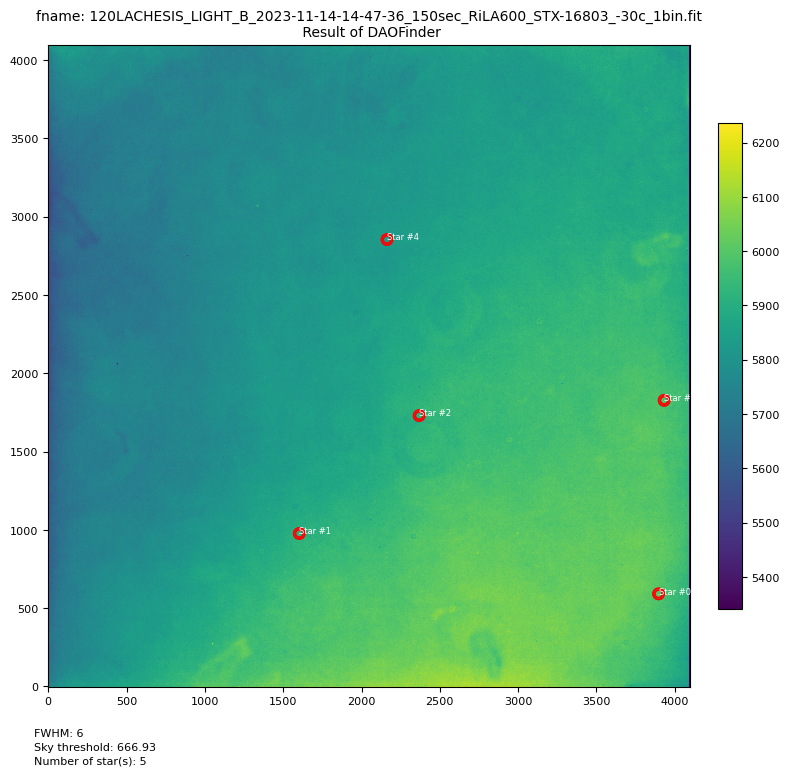

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                        # subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, hdul[0].data, )
axs.set_title('World coordinate system', fontsize=9)
# axs.coords.grid(True, color='white', ls=':')
# axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
# axs.coords['ra'].set_ticklabel_position('bl')
# axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
# axs.coords['dec'].set_ticklabel_position('bl')
# axs.coords['ra'].set_major_formatter('hh:mm')
# axs.coords['dec'].set_major_formatter('dd:mm')
# axs.coords['ra'].display_minor_ticks(True)
# axs.coords['dec'].display_minor_ticks(True)
# axs.coords['ra'].set_minor_frequency(2)
# axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

annul.plot(axs, color="r")
for i in range(len(pos)):
    axs.text(pos[i][0], pos[i][1], f"Star #{str(i)}", fontsize=6, color='w')

annul.plot(axs, color="r")

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.set_title(f"fname: {fpath0.name}\n Result of DAOFinder", fontsize=10,)

axs.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
# plt.savefig(f"{save_dir_name}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

plt.show()

In [53]:
fpath1 = Path('/mnt/Rdata/ASTRO_data/C2-Asteroid/-_-_-_2023-_-_RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_-_2023-11-14_-_RiLA600_STX-16803_-_1bin/120LACHESIS_LIGHT_B_2023-11-14-11-41-03_150sec_RiLA600_STX-16803_-30c_1bin.fit')
fpath1

hdul = fits.open(fpath1)

## thres
# thresh = detect_threshold(data=hdul[0].data, nsigma=3)
# thresh = thresh[0][0]
# print('detect_threshold', thresh)

avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std
# print('detect_threshold', thresh)

DAOfind = DAOStarFinder(
                        fwhm = FWHM, 
                        threshold = thresh, 
                        # sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        # roundlo = -1.0, roundhi = 1.0,  # default values -1 and +1
                        # sigma_radius = 1.5,           # default values 1.5
                        # ratio = 1.0,                  # 1.0: circular gaussian
                        exclude_border = True         # To exclude sources near edges
                        )
# The DAOStarFinder object ("DAOfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
DAOfound = DAOfind(hdul[0].data)
print("DAOfound :", DAOfound)
print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)

DAOfound :  id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
  1   537.976840453148 ...  4.093940951368596    -1.5303539358994351
  2  588.0921595611945 ... 10.865663679799065     -2.590140645939936
  3 3323.1149902514394 ... 2.3523803485421153     -0.928768856773809
  4 4037.3728264942465 ... 1.1032977794433314   -0.10673186023751155
  5 403.33271492622504 ...  5.134047005223981    -1.7761496014384561
  6 3480.6107558871186 ...  7.332854689551578    -2.1631826973686157
  7 1650.3252780698379 ... 1.0550295354049997   -0.05816154454367329
  8  1206.473733908671 ... 1.0440502375625644   -0.04680349132863832
  9 3028.7402018670327 ... 51.033038835287066    -4.2696285744707225
 10  635.8567168587876 ...  10.28605302218633     -2.530621896692114
...                ... ...                ...                    ...
 78  427.4819990232115 ...  6.176554795473708    -1.9768657465702242
 79 1036.1333145142726 

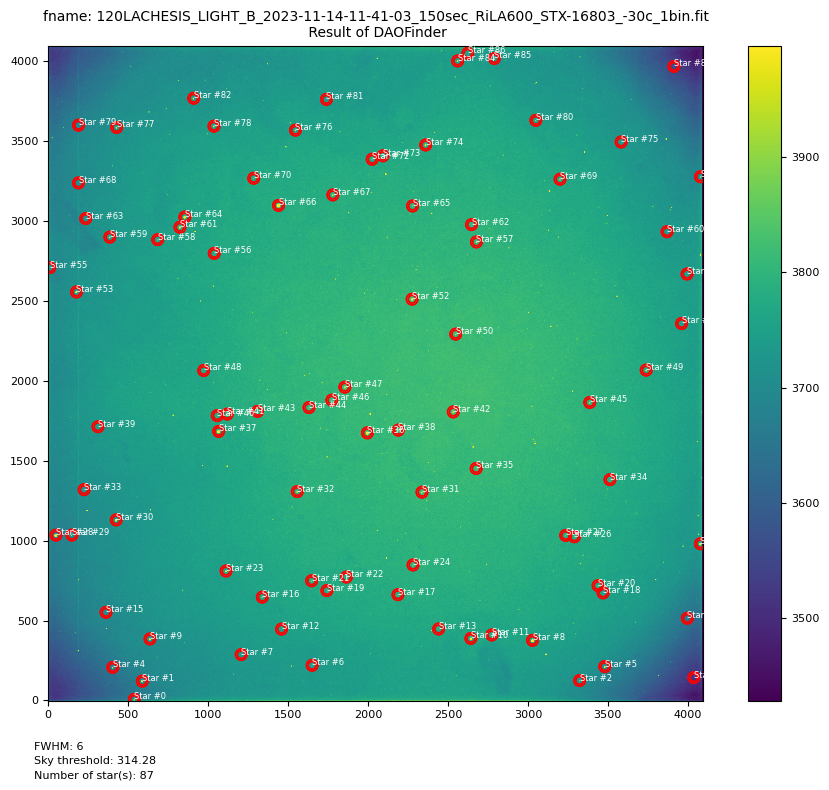

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8),
                        # subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, hdul[0].data, )
# axs.set_title('World coordinate system', fontsize=9)
# axs.coords.grid(True, color='white', ls=':')
# axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
# axs.coords['ra'].set_ticklabel_position('bl')
# axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
# axs.coords['dec'].set_ticklabel_position('bl')
# axs.coords['ra'].set_major_formatter('hh:mm')
# axs.coords['dec'].set_major_formatter('dd:mm')
# axs.coords['ra'].display_minor_ticks(True)
# axs.coords['dec'].display_minor_ticks(True)
# axs.coords['ra'].set_minor_frequency(2)
# axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

annul.plot(axs, color="r")
for i in range(len(pos)):
    axs.text(pos[i][0], pos[i][1], f"Star #{str(i)}", fontsize=6, color='w')

annul.plot(axs, color="r")

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.set_title(f"fname: {fpath1.name}\n Result of DAOFinder", fontsize=10,)

axs.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
# plt.savefig(f"{save_dir_name}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

plt.show()